In [1]:
import numpy as np
import utils
from sdecgmca import SDecGMCA
import healpytools as hpyt

# Problem setup

In [2]:
# Initialize the parameters of the problem
n = 4                       # number of sources
m = 8                       # number of observations
nside = 128                 # Healpix nside
lmax = np.int(3*nside)      # maximum frequency of the projection in the spherical harmonic space
cutmin = np.int(0.5*nside)  # source generation: frequency at which the band-limiting filter starts to cut
cutmax = np.int(3*nside)    # source generation: frequency above which the alm are fixed to 0
nscales = 3                 # source generation: number of WT scales
sparseLvl = 2               # source generation: desired sparsity level in WT domain (corresponds to a k*std per scale)
condn = 2                   # mixing matrix generation: condition number of the mixing matrix
max0s = 0                   # mixing matrix generation: max nb of zeros (may be relaxed)
minResol = np.int(lmax/8)   # fwhm in the spherical harmonic space of the observation with the worse resolution
maxResol = np.int(lmax)     # fwhm in the spherical harmonic space of the observation with the best resolution
snr = 10                    # SNR in dB
verb = 0                    # verbosity level

In [3]:
# Generate the joint deconvolution and BSS problem
A0, S0, Hl, X, N, Y = utils.generate_problem(n=n, m=m, nside=nside, lmax=lmax, cutmin=cutmin, cutmax=cutmax,
                                             nscales=nscales, sparseLvl=sparseLvl, condn=condn, max0s=max0s,
                                             minResol=minResol, maxResol=maxResol, snr=snr, verb=verb)
S0c = hpyt.convolve(S0, Hl[-1, :])

A =
 [[0.04814908 0.41384713 0.0525093  0.00611334]
 [0.62402551 0.12070746 0.45320681 0.03480939]
 [0.07980687 0.62605694 0.05423333 0.03863147]
 [0.06991886 0.22059124 0.22262069 0.96961006]
 [0.67722572 0.32011376 0.         0.20527961]
 [0.03760881 0.32558721 0.81686691 0.11810022]
 [0.36655998 0.07090499 0.26621905 0.02044745]
 [0.05099735 0.40005638 0.03465562 0.02468588]]


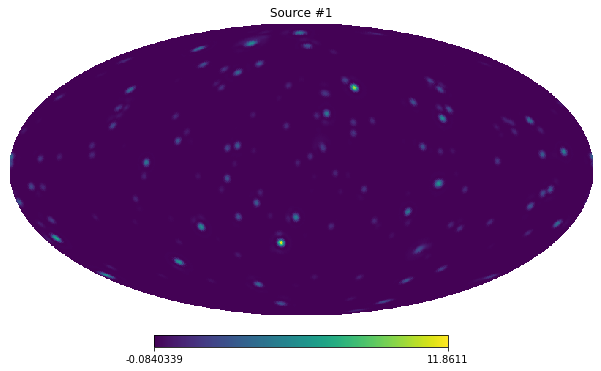

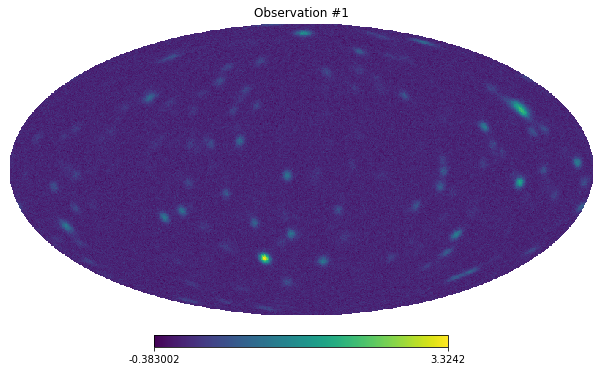

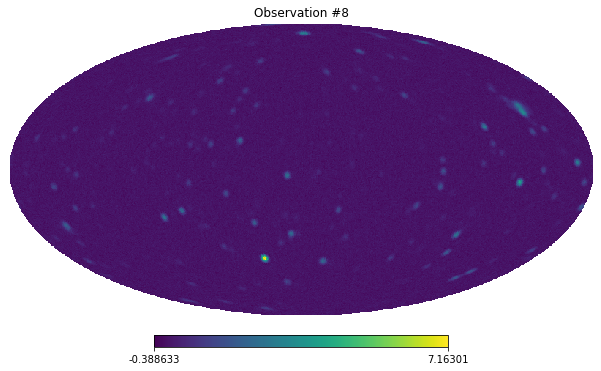

In [4]:
# View the data
print("A =\n", A0)
hpyt.mollview(S0[0,:], title='Source #1')
hpyt.mollview(Y[0,:], title='Observation #1')
hpyt.mollview(Y[-1,:], title='Observation #8')

# Joint deconvolution and blind source separation

In [5]:
# Initialize the parameters of SDecGMCA
minWuIt = 100                       # minimum number of iterations at warm-up
c_wu = 0.5*np.array([1, 10])        # Tikhonov regularization hyperparameter at warm-up
c_ref = 0.5                         # Tikhonov regularization hyperparameter at refinement
cwuDec = 50                         # number of iterations for the decrease of c_wu
nStd = np.std(N)                    # noise standard deviation
useMad = False                      # use mad to estimate noise std in source space
nscales = 3                         # number of detail scales
k = 3                               # parameter of the k-std thresholding
K_max = 0.5                         # maximal L0 norm of the sources
L1 = True                           # L1 penalization
doRw = True                         # do l1 reweighing during refinement
eps = np.array([1e-2, 1e-6, 1e-4])  # stopping criteria

In [6]:
# Set the algorithm
sdecgmca = SDecGMCA(Y, Hl/Hl[-1, :], n, minWuIt=minWuIt, c_wu=c_wu, c_ref=c_ref, cwuDec=cwuDec,nStd=nStd, 
                    useMad=useMad, nscales=nscales, k=k, K_max=K_max, L1=L1, doRw=doRw, eps=eps, verb=verb)

In [7]:
# Run the algorithm
sdecgmca.run()
S = sdecgmca.S
A = sdecgmca.A

CA : 30.13 | NMSE: 25.83


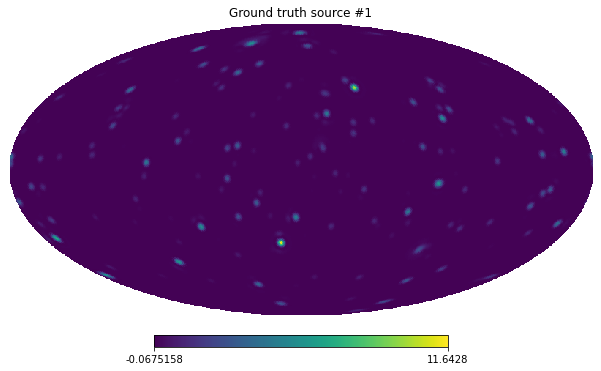

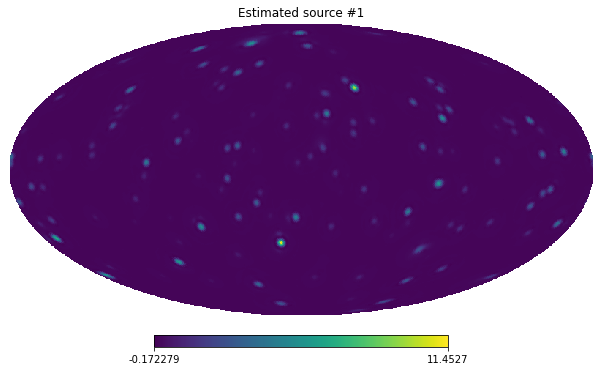

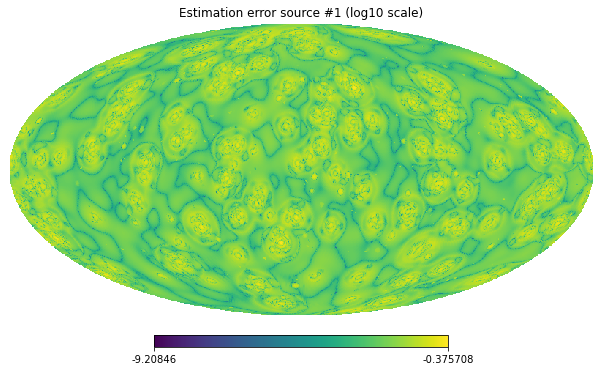

In [8]:
# Assess solution
utils.asses_solution(A0, S0c, A, S, corrPerm=True, view=False)
hpyt.mollview(S0c[0,:], title='Ground truth source #1')
hpyt.mollview(S[0,:], title='Estimated source #1')
hpyt.mollview(np.log10(np.abs(S0[0,:]-S[0,:])), title='Estimation error source #1 (log10 scale)')